<a href="https://colab.research.google.com/github/alphas7/Santander-Customer-Satisfaction/blob/master/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip -uq "/content/drive/My Drive/Santander_Customer_Satisfaction/pickle_files.zip" -d "/content/"

In [60]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
from sklearn.manifold import TSNE
import sklearn
from sklearn import metrics
from sklearn import cluster
import scipy
import random
from tqdm import tqdm

In [4]:
train = pd.read_pickle('pickle_files/train_1.pkl')
test = pd.read_pickle('pickle_files/test_1.pkl')

In [5]:
X_test = test.copy()
X_train = train.copy()
X_train.shape,X_test.shape

((76020, 144), (75818, 143))

# No. of zeros

In [55]:
def add_feature_no_zeros(train=X_train,test=X_test):
    """
    Add feature which tells the no. of occurences of zeros across a datapoint
    """
    col = [k for k in train.columns if k!='TARGET']
    for df in [train,test]:
        df['no_zeros'] = (df.loc[:,col]==0).sum(axis=1).values

In [56]:
def add_feature_no_zeros_keyword(keyword,train=X_train,test=X_test):
    """
    Add feature which tells the no. of occurences of zeros across a datapoint
    for a specific keyword
    """
    col = [k for k in train.columns if keyword in k]
    for df in [train,test]:
        df['no_zeros_'+k] = (df.loc[:,col]==0).sum(axis=1).values

In [57]:
#adding no. of zeros feature
add_feature_no_zeros()
X_train.shape,X_test.shape

((76020, 145), (75818, 144))

In [58]:
keywords = ['saldo' , 'ind', 'num', 'imp']
for k in keywords:
  add_feature_no_zeros_keyword(k)
X_train.shape,X_test.shape

((76020, 149), (75818, 148))

Taking average values for each unique values of a categorical feature for all 'saldo' and 'imp' features

In [59]:
def average_col(col,features,train=X_train,test=X_test):
  """
  Gets the average numerical values of features for each category in 'col' feature
  and add it as feature 
  """
  for df in [train,test]:
    unique_values = df[col].unique()
    
    for feature in features:
      avg_value=[]
      for value in unique_values:
        avg = df.loc[df[col]==value,feature].mean() #taking average for each category for feature col
        avg_value.append(avg)
      avg_dict = dict(zip(unique_values,avg_value))
      new_col = 'avg_'+col+'_'+feature
      df[new_col] = np.zeros(df.shape[0])
      for value in unique_values:
        df.loc[df[col]==value,new_col] = avg_dict[value]

In [60]:
%%time
#we will be taking average columns for saldo and imp with categorical columns being the ones that have between 50 and 200 unqiue values
features = [i for i in X_train.columns if ('saldo' in i) & ('no_zeros' not in i)]
features.extend([i for i in X_train.columns if ('imp' in i) & ('no_zeros' not in i)])
columns = [i for i in X_train.columns if (X_train[i].nunique()<=200) & (X_train[i].nunique()>50)]

for col in tqdm(columns):
  average_col(col,features)






  0%|          | 0/16 [00:00<?, ?it/s]




  6%|▋         | 1/16 [00:13<03:19, 13.28s/it]




 12%|█▎        | 2/16 [00:30<03:24, 14.60s/it]




 19%|█▉        | 3/16 [00:57<03:54, 18.04s/it]




 25%|██▌       | 4/16 [01:17<03:44, 18.70s/it]




 31%|███▏      | 5/16 [01:46<03:59, 21.73s/it]




 38%|███▊      | 6/16 [02:08<03:39, 21.98s/it]




 44%|████▍     | 7/16 [02:31<03:19, 22.16s/it]




 50%|█████     | 8/16 [03:01<03:16, 24.53s/it]




 56%|█████▋    | 9/16 [03:24<02:48, 24.11s/it]




 62%|██████▎   | 10/16 [03:55<02:38, 26.35s/it]




 69%|██████▉   | 11/16 [04:27<02:19, 27.84s/it]




 75%|███████▌  | 12/16 [04:54<01:50, 27.56s/it]




 81%|████████▏ | 13/16 [05:29<01:29, 29.74s/it]




 88%|████████▊ | 14/16 [06:22<01:13, 36.92s/it]




 94%|█████████▍| 15/16 [07:04<00:38, 38.23s/it]




100%|██████████| 16/16 [07:34<00:00, 28.38s/it]

CPU times: user 7min 26s, sys: 7.19 s, total: 7min 33s
Wall time: 7min 34s


# K-Means Clustering

In [88]:
#https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
# We will use silhouete score to determine the best k. silhouette score : highest score shows best k.

kminmax = [2,10]
k = np.arange(kminmax[0],kminmax[1]+1,2)
k

array([ 2,  4,  6,  8, 10])

In [89]:
X =X_train.drop('TARGET',axis=1)
sil_score = []
sse = []
for i in tqdm(k):
  kmeans = cluster.KMeans(n_clusters=i,n_jobs=-1,verbose=2,random_state=100)
  kmeans.fit(X)
  labels = kmeans.predict(X)
  score = metrics.silhouette_score(X,labels,random_state=100)
  sil_score.append(score)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [08:17<33:11, 497.97s/it]

 40%|████      | 2/5 [16:56<25:12, 504.15s/it]

 60%|██████    | 3/5 [26:20<17:24, 522.10s/it]

 80%|████████  | 4/5 [36:33<09:09, 549.25s/it]

100%|██████████| 5/5 [47:46<00:00, 573.35s/it]


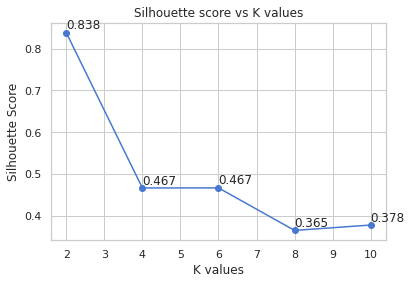

In [90]:
plt.title('Silhouette score vs K values')
sns.lineplot(x=k,y=sil_score)
plt.scatter(x=k,y=sil_score)
for i, txt in enumerate(range(len(sil_score))):
    plt.annotate("%.3f"%(sil_score[i]), (k[i], sil_score[i]+0.009))
plt.xlabel('K values')
plt.ylabel('Silhouette Score')
plt.show()

We can see that silhouette score is highest for k=2. We can add k means cluster values for 2,3 and 4 as features.

In [91]:
def add_kmeans_cluster(ncluster=[2,3,4],train=X_train,test=X_test):
  """
  Function add Kmeans cluster value as features for n in ncluster
  """
  X_tr = train.drop('TARGET',axis=1)
  X_te = test.copy()
  for n in ncluster:
    print("for n=%i:"%(n))
    feat_name = 'Kmeans_'+str(n)
    kmeans = cluster.KMeans(n_clusters=n,n_jobs=-1,verbose=2,random_state=100)
    train[feat_name] = kmeans.fit_predict(X_tr)
    test[feat_name] = kmeans.predict(X_te)


In [92]:
%%time
add_kmeans_cluster()

for n=2:
for n=3:
for n=4:
CPU times: user 6.86 s, sys: 1.28 s, total: 8.14 s
Wall time: 7min 44s


In [ ]:
# X_train.to_pickle('/content/drive/My Drive/Santander_Customer_Satisfaction/X_train_2.pkl')
# X_test.to_pickle('/content/drive/My Drive/Santander_Customer_Satisfaction/X_test_2.pkl')
X_train=pd.read_pickle('/content/drive/My Drive/Santander_Customer_Satisfaction/X_train_2.pkl')
X_test = pd.read_pickle('/content/drive/My Drive/Santander_Customer_Satisfaction/X_test_2.pkl')
X_train.shape,X_test.shape

# Feature Selection

In [52]:
#correlation target values
corr_target = pd.DataFrame(X_train.corr().abs()['TARGET']).sort_values(by='TARGET')
threshold=10**-3
feat_df =corr_target[(corr_target['TARGET'])<=threshold]

In [54]:
#removing all low correlated variables with target


print("There are %i features that have a correlation values less than %.3f with 'TARGET'. We will remove all of this."\
      %(feat_df.shape[0],threshold))
print("Removing.........")

for df in [X_train,X_test]:
  df.drop(feat_df.index,axis=1,inplace=True)


There are 39 features that have a correlation values less than 0.001 with 'TARGET'. We will remove all of this.
Removing.........


In [55]:
X_train.shape,X_test.shape

((76020, 750), (75818, 749))

In [56]:
del corr_target,threshold,feat_df

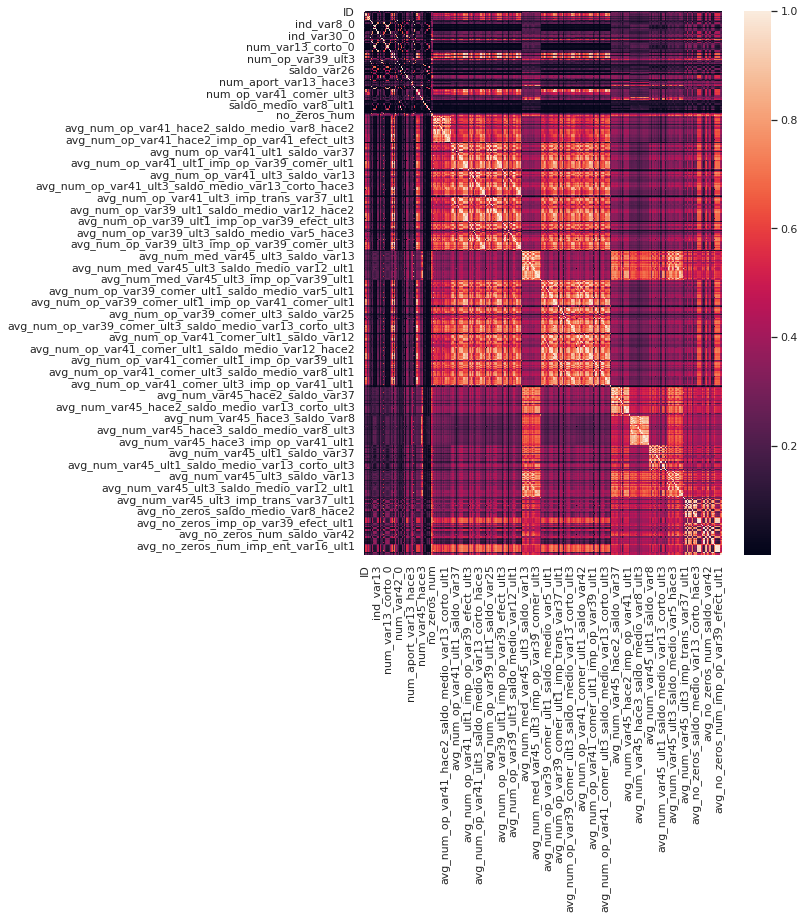

In [59]:
corr = X_train.corr().abs()


# Applying log transformation to 'saldo' and 'imp' features 

In [ ]:
def apply_log(train,test,col):
  """
  apply log transformation to all features in col variable
  """
  for df in [train,test]:
    df.loc[:,col] = np.log(df.loc[:,col].values)
  
  return train,test

In [ ]:
features = [i for i in X_train.columns if ('saldo' in i)|('imp' in i)]

['imp_ent_var16_ult1',
 'imp_op_var39_comer_ult1',
 'imp_op_var39_comer_ult3',
 'imp_op_var41_comer_ult1',
 'imp_op_var41_comer_ult3',
 'imp_op_var41_efect_ult1',
 'imp_op_var41_efect_ult3',
 'imp_op_var41_ult1',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'imp_op_var39_ult1',
 'saldo_var5',
 'saldo_var8',
 'saldo_var12',
 'saldo_var13_corto',
 'saldo_var13',
 'saldo_var24',
 'saldo_var26',
 'saldo_var25',
 'saldo_var30',
 'saldo_var37',
 'saldo_var42',
 'imp_aport_var13_hace3',
 'imp_var43_emit_ult1',
 'imp_trans_var37_ult1',
 'saldo_medio_var5_hace2',
 'saldo_medio_var5_hace3',
 'saldo_medio_var5_ult1',
 'saldo_medio_var5_ult3',
 'saldo_medio_var8_hace2',
 'saldo_medio_var8_ult1',
 'saldo_medio_var8_ult3',
 'saldo_medio_var12_hace2',
 'saldo_medio_var12_hace3',
 'saldo_medio_var12_ult1',
 'saldo_medio_var12_ult3',
 'saldo_medio_var13_corto_hace2',
 'saldo_medio_var13_corto_hace3',
 'saldo_medio_var13_corto_ult1',
 'saldo_medio_var13_corto_ult3',
 'no_zeros_saldo',
 'no_z

# One Hot Encoding

In [69]:
#getting all columns with less than or equal to 10 nunique values
cat_col = []
for col in X_train.columns:
  if (X_train[col].nunique()<=10) & (col!='TARGET') & (X_train[col].nunique()>2):
    cat_col.append(col)
print("There are %i columns which have less than or equal to 10 and greater than 2 number of unique values. \nWe will create \
new datasets which use one hot encoding,\
response encoding and also leaving the columns as it is."%(len(cat_col)))

There are 31 columns which have less than or equal to 10 and greater than 2 number of unique values. 
We will create new datasets which use one hot encoding,response encoding and also leaving the columns as it is.


In [70]:
def one_hot_encoding(col,train=X_train,test=X_test):
  """
  one hot encodes all the features in col array in all X dataset
  """
  ohe = sklearn.preprocessing.OneHotEncoder(sparse=True,handle_unknown='ignore')
  ohe.fit(train.loc[:,col])
  feature_names = list(ohe.get_feature_names(input_features=col))
  features = list(train.drop(col,axis=1).columns)
  features.extend(feature_names)

  #train
  df = train.copy()
  temp = ohe.transform(df[cat_col])
  df.drop(col,axis=1,inplace=True)
  train = pd.DataFrame(scipy.sparse.hstack([df.values,temp]).toarray(),columns=features).copy()


  #test
  df = test.copy()
  temp = ohe.transform(df[cat_col])
  df.drop(col,axis=1,inplace=True)
  features.remove('TARGET')
  test = pd.DataFrame(scipy.sparse.hstack([df.values,temp]).toarray(),columns=features).copy()

  return train,test

In [71]:
X_train_ohe,X_test_ohe = one_hot_encoding(cat_col)
X_train_ohe.shape,X_test_ohe.shape

((76020, 932), (75818, 931))

# Response Encoding

In [72]:
def response_encoding_return(df,column,target,alpha=5000):
    """
    Here we are using response encoding with laplace smoothing to a categorical column
    and transform the respective column in train,test,val datasets.
    Here we will be repeating the values of each category alpha times.
    the function will return the response encoding values of each categorical value in that column
    """
    unique_values = set(df[column].values)
    dict_values = {}
    for value in unique_values:
        total = len(df[df[column]==value])
        sum_promoted = len(df[(df[column]==value) & df[target]==1])
        dict_values[value] = np.round((sum_promoted+alpha)/(total+alpha*len(unique_values)),2)
    return dict_values

In [73]:
def response_encoding(df,test_df,column,target='TARGET',alpha=5000):
    """
    Here we are using response encoding with laplace smoothing to a categorical column
    and transform the respective column in train,test,val datasets.
    Here we will be repeating the values of each category alpha times.
    """
    unique_values = set(df[column].values) #all unique values in that categorical column
    dict_values = {}
    for value in unique_values:
        total = len(df[df[column]==value]) #the total no. of datapoints with 'value' catgeory
        sum_promoted = len(df[(df[column]==value) & df[target]==1]) #sum of all datapoints with category being 'value' and target==1
        dict_values[value] = np.round((sum_promoted+alpha)/(total+alpha*len(unique_values)),2) #storing the obtained result in a dictionary
    dict_values['unknown']=0.5 #unknown categories that are not seen in train will be assigned a score of 0.5
    df[column]=(df[column].map(dict_values)).values
    unique_values_test = set(test_df[column].values)
    test_df[column]=test_df[column].apply(lambda x: 'unknown' if x in (unique_values_test-unique_values) else x )
    test_df[column] = (test_df[column].map(dict_values)).values

In [74]:
# finding the best alpha
random.seed(100)
ran_in = random.randint(0,10)
col = [col for col in cat_col if X_train[col].nunique()>3][ran_in]
col
print('Feature: "%s"'%(col))
for alpha in [100,500,1000,2500,5000,10000]:
  print('for alpha %i:%s'%(alpha,response_encoding_return(X_train,col,"TARGET",alpha=alpha)))

Feature: "num_var5_0"
for alpha 100:{0: 0.09, 3: 0.04, 6: 0.13, 9: 0.2, 15: 0.2}
for alpha 500:{0: 0.13, 3: 0.04, 6: 0.18, 9: 0.2, 15: 0.2}
for alpha 1000:{0: 0.15, 3: 0.05, 6: 0.19, 9: 0.2, 15: 0.2}
for alpha 2500:{0: 0.17, 3: 0.06, 6: 0.19, 9: 0.2, 15: 0.2}
for alpha 5000:{0: 0.19, 3: 0.08, 6: 0.2, 9: 0.2, 15: 0.2}
for alpha 10000:{0: 0.19, 3: 0.1, 6: 0.2, 9: 0.2, 15: 0.2}


In [75]:
random.seed(1000)
ran_in = random.randint(0,10)
col = [col for col in cat_col if X_train[col].nunique()>3][ran_in]
# finding the best alpha
print('Feature: "%s"'%(col))
for alpha in [100,500,1000,2500,5000,10000]:
  print('for alpha %i:%s'%(alpha,response_encoding_return(X_train,col,"TARGET",alpha=alpha)))

Feature: "num_var13_0"
for alpha 100:{0: 0.04, 3: 0.03, 6: 0.11, 9: 0.14, 12: 0.14, 15: 0.14, 18: 0.14}
for alpha 500:{0: 0.05, 3: 0.07, 6: 0.14, 9: 0.14, 12: 0.14, 15: 0.14, 18: 0.14}
for alpha 1000:{0: 0.05, 3: 0.1, 6: 0.14, 9: 0.14, 12: 0.14, 15: 0.14, 18: 0.14}
for alpha 2500:{0: 0.06, 3: 0.12, 6: 0.14, 9: 0.14, 12: 0.14, 15: 0.14, 18: 0.14}
for alpha 5000:{0: 0.07, 3: 0.13, 6: 0.14, 9: 0.14, 12: 0.14, 15: 0.14, 18: 0.14}
for alpha 10000:{0: 0.09, 3: 0.14, 6: 0.14, 9: 0.14, 12: 0.14, 15: 0.14, 18: 0.14}


Looking at the above two features, the best alpha was found to be alpha=100.

In [76]:
#response encoding features
alpha=100
X_train_re = X_train.copy()
X_test_re = X_test.copy()
for col in tqdm(cat_col):
  response_encoding(X_train_re,X_test_re,col,alpha=alpha)

X_train_re.shape,X_test_re.shape

((76020, 789), (75818, 788))

In [ ]:
#

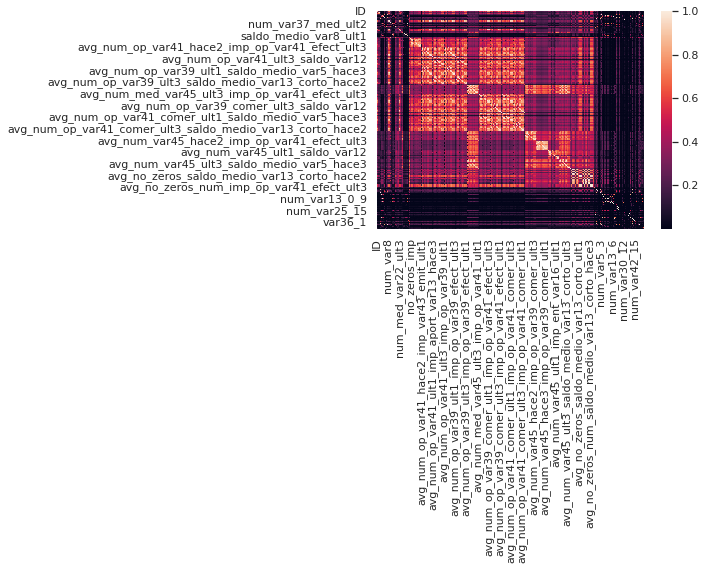

In [81]:
X_train_ohe.corr().abs()